# Calibration of camera

newdata\WIN_20250304_21_09_59_Pro.jpg
True


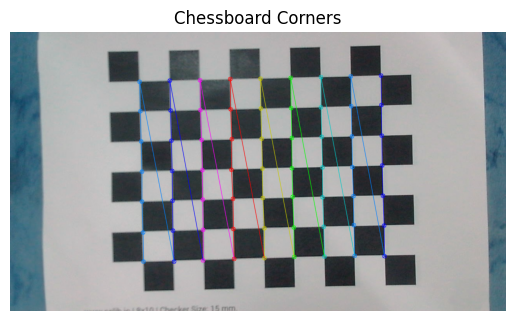

True


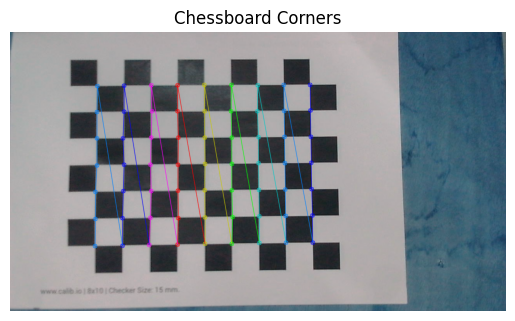

True


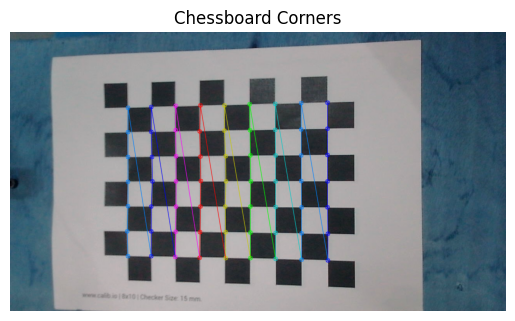

True


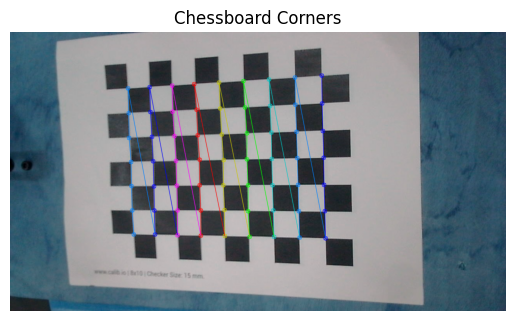

True


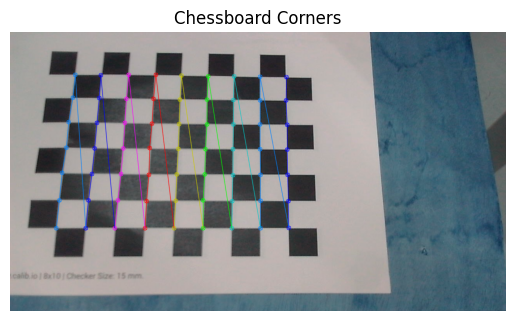

True


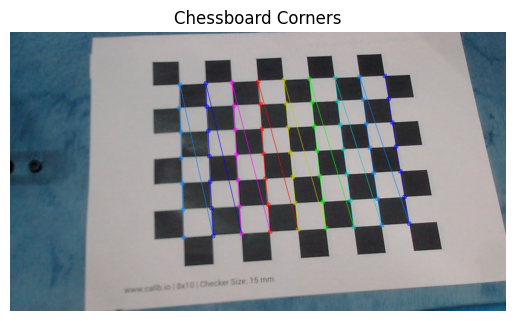

True


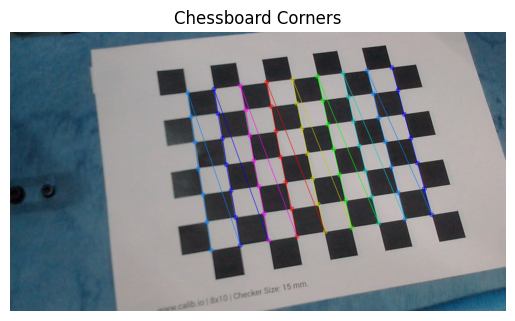

True


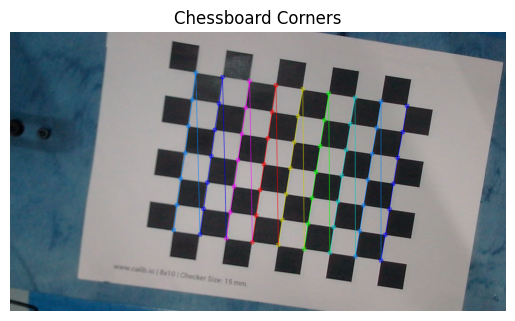

True


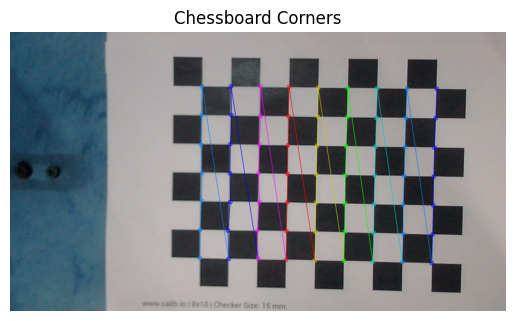

Camera Matrix (K):
 [[1.43057162e+03 0.00000000e+00 6.75252736e+02]
 [0.00000000e+00 1.42228592e+03 3.75255856e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients:
 [ 2.50151141e-01 -2.15202603e+00  2.83665753e-03 -2.00932362e-04
  6.78654535e+00]
Reprojection Error: 0.13081147270827131


In [1]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
# Chessboard size (change this based on your checkerboard pattern)
chessboard_size = (7,9)  # Number of internal corners in the chessboard (width, height)
square_size = 1  # Size of a square in some unit (e.g., mm, cm)

# Prepare object points (3D points in real-world space)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size  # Scale by the square size

# Arrays to store object points and image points
objpoints = []  # 3D points in real-world coordinates
imgpoints = []  # 2D points in image plane

# Load calibration images
image_paths = glob.glob('newdata/*.jpg')  # Select first 6 images
print(image_paths[0])

for fname in image_paths:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray)

    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    print(ret)

    if ret:
        objpoints.append(objp)  # Store 3D points
        imgpoints.append(corners)  # Store 2D points

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # just show the resuts Use Matplotlib to display the image
        plt.imshow(cv2.drawChessboardCorners(img, chessboard_size, corners, ret))
        plt.title("Chessboard Corners")
        plt.axis('off')  # Hide axis
        plt.show()

cv2.destroyAllWindows()

# Perform camera calibration
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# # Compute reprojection error
reprojection_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], K, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2) / len(imgpoints2)
    reprojection_error += error

reprojection_error /= len(objpoints)

# Display results
print("Camera Matrix (K):\n", K)
print("Distortion Coefficients:\n", dist.ravel())
print("Reprojection Error:", reprojection_error)

# Undistort the images

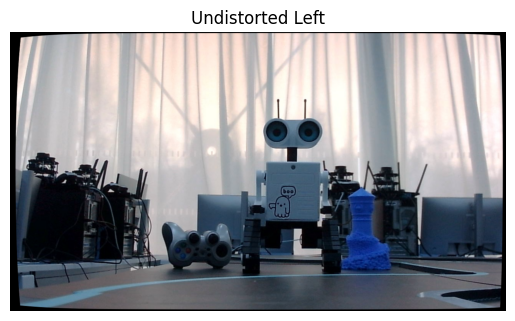

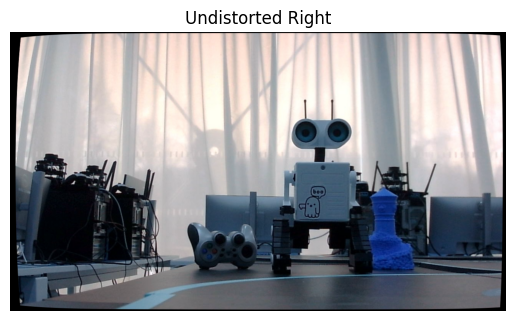

In [ ]:

# Load previously computed camera matrix (K) and distortion coefficients (dist)
# K and dist are obtained from the calibration step

# Load images to be undistorted
left_img = cv2.imread("first/1.jpg")
right_img = cv2.imread("first/2.jpg")

# Convert to grayscale for shape reference
h, w = left_img.shape[:2]

# # Get new camera matrix to optimize field of view
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K, dist, (w, h), 1, (w, h))

# Undistort images
undistorted_left = cv2.undistort(left_img, K, dist, None, new_camera_matrix)
undistorted_right = cv2.undistort(right_img, K, dist, None, new_camera_matrix)

undistorted_left = cv2.undistort(left_img, K, dist)
undistorted_right = cv2.undistort(right_img, K, dist)

plt.imshow(undistorted_left)
plt.title("Undistorted Left")
plt.axis('off')  # Hide axis
plt.show()

plt.imshow(undistorted_right)
plt.title("Undistorted Right")
plt.axis('off')  # Hide axis
plt.show()



# Rectification of Left and Right images


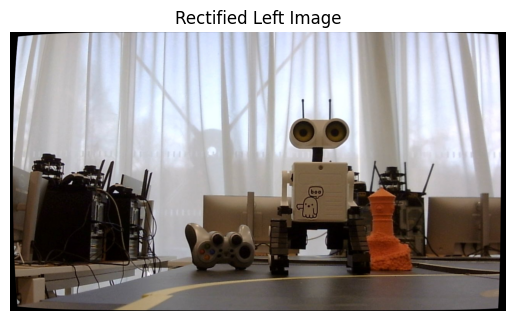

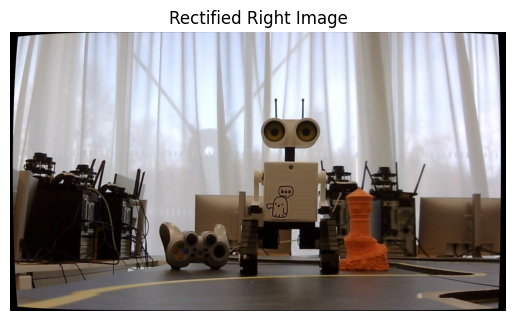

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def rectify_images(img1, img2, K, dist_coeffs, T):
    # Extract rotation (R) and translation (t)
    R = T[:3, :3]  # Extract rotation from transformation matrix
    t = T[:3, 3]   # Extract translation



    # Perform stereo rectification
    R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(
        K, dist_coeffs,  # Camera 1 intrinsics and distortion
        K, dist_coeffs,  # Camera 2 intrinsics and distortion
        img1.shape[:2][::-1],  # Image size (width, height)
        R, t, 
        flags=cv2.CALIB_ZERO_DISPARITY,
        alpha=1  # 1 = No cropping
    )

    # Compute rectification maps
    map1_x, map1_y = cv2.initUndistortRectifyMap(K, dist_coeffs, R1, P1, img1.shape[:2][::-1], cv2.CV_32FC1)
    map2_x, map2_y = cv2.initUndistortRectifyMap(K, dist_coeffs, R2, P2, img2.shape[:2][::-1], cv2.CV_32FC1)

    # Rectify images
    img1_rectified = cv2.remap(img1, map1_x, map1_y, cv2.INTER_LINEAR)
    img2_rectified = cv2.remap(img2, map2_x, map2_y, cv2.INTER_LINEAR)

    return img1_rectified, img2_rectified, Q

# Load undistorted images
img1 = cv2.imread("2.jpg")  # First image
img2 = cv2.imread("1.jpg")  # Second image

# Camera parameters (already defined)
# K - Camera intrinsic matrix
# dist_coeffs - Distortion coefficients

# Define transformation matrix
T = np.eye(4)
T[:3, 3] = np.array([0.12, 0, 0])  # Translation: 12 cm along x-axis

# Rectify images
rectified_img1, rectified_img2, Q = rectify_images(img1, img2, K, dist, T)
# Save or display rectified images
cv2.imwrite('rectified_img1.jpg', rectified_img1)
cv2.imwrite('rectified_img2.jpg', rectified_img2)

plt.imshow(cv2.cvtColor(rectified_img1, cv2.COLOR_BGR2RGB))
plt.title("Rectified Left Image")
plt.axis('off')
plt.show()

plt.imshow(cv2.cvtColor(rectified_img2, cv2.COLOR_BGR2RGB))
plt.title("Rectified Right Image")
plt.axis('off')
plt.show()


# Rectified Images with Epipolar Lines

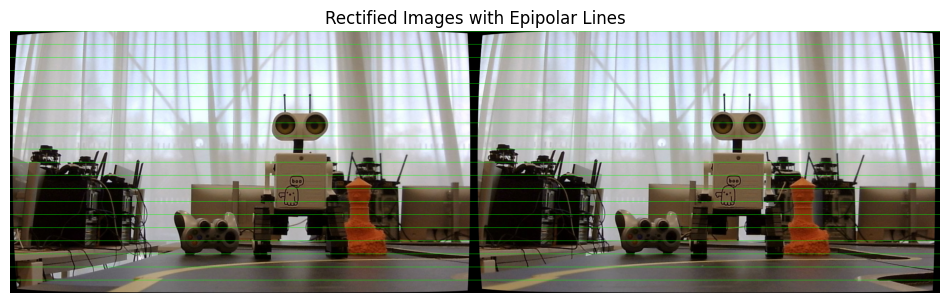

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load rectified images
rectified1 = cv2.imread("rectified_img1.jpg")
rectified2 = cv2.imread("rectified_img2.jpg")

# Convert to grayscale for visualization consistency
rectified1_gray = cv2.cvtColor(rectified1, cv2.COLOR_BGR2GRAY)
rectified2_gray = cv2.cvtColor(rectified2, cv2.COLOR_BGR2GRAY)

# Define the number of epipolar lines
num_lines = 20  # Adjust based on image size
height, width = rectified1_gray.shape

# Select evenly spaced y-coordinates
step = height // num_lines
y_coords = np.arange(0, height, step)

# Draw epipolar lines
for y in y_coords:
    cv2.line(rectified1, (0, y), (width, y), (0, 255, 0), 1)
    cv2.line(rectified2, (0, y), (width, y), (0, 255, 0), 1)

# Stack images side by side for visualization
combined = np.hstack((rectified1, rectified2))

# Display the images
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(combined, cv2.COLOR_BGR2RGB))
plt.title("Rectified Images with Epipolar Lines")
plt.axis("off")
plt.show()


# Case 1: 3D reconstruction by depth map

## Using Stereo block matching algorithm

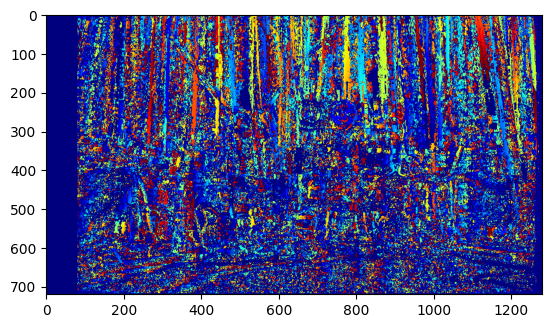

In [5]:
# import OpenCV and pyplot 
import cv2 as cv 
from matplotlib import pyplot as plt 

# read left and right images 
imgR = cv.imread('rectified_img1.jpg', 0) 
imgL = cv.imread('rectified_img2.jpg', 0) 

# creates StereoBm object 
stereo = cv.StereoBM_create(numDisparities = 16*5, 
							blockSize = 5) 

# computes disparity 
disparity = stereo.compute(imgL, imgR) 

# displays image as grayscale and plotted 
plt.imshow(disparity, 'jet') 
plt.show() 


## Using StereoSGBM algorithm

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


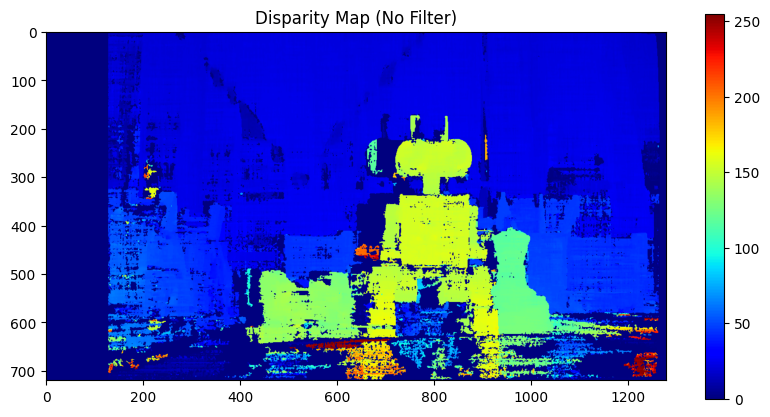

3D point cloud saved as output.ply


In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

# Load rectified stereo images
left_img_color = cv2.imread("rectified_img1.jpg")  # Load in color (BGR)
left_img = cv2.cvtColor(left_img_color, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
right_img = cv2.imread("rectified_img2.jpg", cv2.IMREAD_GRAYSCALE)

# Define StereoSGBM parameters
min_disparity = 0
num_disparities = 128  # Must be a multiple of 16
block_size = 1
uniqueness_ratio = 10
speckle_window_size = 100
speckle_range = 32
disp12_max_diff = 1
pre_filter_cap = 63

# Create StereoSGBM object
stereo = cv2.StereoSGBM_create(
    minDisparity=min_disparity,
    numDisparities=num_disparities,
    blockSize=block_size,
    uniquenessRatio=uniqueness_ratio,
    speckleWindowSize=speckle_window_size,
    speckleRange=speckle_range,
    disp12MaxDiff=disp12_max_diff,
    P1=8 * 3 * block_size**2,
    P2=32 * 3 * block_size**2,
    preFilterCap=pre_filter_cap,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
    
)

# Compute disparity map
disparity = stereo.compute(left_img, right_img).astype(np.float32) / 16.0

# Normalize disparity for visualization
disparity_norm = cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_norm = np.uint8(disparity_norm)

# Show results
plt.figure(figsize=(10, 5))
plt.imshow(disparity_norm, cmap="jet")
plt.colorbar()
plt.title("Disparity Map (No Filter)")
plt.show()


# Convert disparity to 3D space
points_3D = cv2.reprojectImageTo3D(disparity, Q)

# Create a valid mask (avoid NaNs, infinities, and zero disparity)
mask = (disparity > 10) & np.isfinite(points_3D[:, :, 0])

# Extract valid 3D points
points = points_3D[mask]

# Extract corresponding colors from the left image
colors = left_img_color[mask]  # Extract RGB values

# Normalize colors (Open3D requires values in range [0,1])
colors = colors.astype(np.float32) / 255.0

### **Step 3: Convert to Open3D and Save as PLY**
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)  # Assign colors to point cloud

# Save and visualize the 3D point cloud
o3d.io.write_point_cloud("output.ply", pcd)
o3d.visualization.draw_geometries([pcd])

print("3D point cloud saved as output.ply")


## Using StereoSGBM algorithm + Weighted least square (WLS)

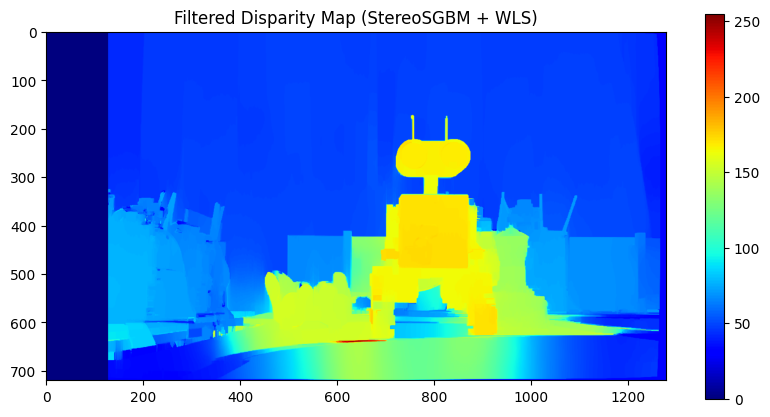

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

# Load rectified stereo images
left_img_color = cv2.imread("rectified_img1.jpg")  # Load in color (BGR)
left_img = cv2.cvtColor(left_img_color, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
right_img = cv2.imread("rectified_img2.jpg", cv2.IMREAD_GRAYSCALE)

# Define StereoSGBM parameters
min_disparity = 0
num_disparities = 128  # Must be a multiple of 16
block_size = 5
uniqueness_ratio = 10
speckle_window_size = 100
speckle_range = 32
disp12_max_diff = 1
pre_filter_cap = 63

# Create StereoSGBM object for left and right images
stereo_left = cv2.StereoSGBM_create(
    minDisparity=min_disparity,
    numDisparities=num_disparities,
    blockSize=block_size,
    uniquenessRatio=uniqueness_ratio,
    speckleWindowSize=speckle_window_size,
    speckleRange=speckle_range,
    disp12MaxDiff=disp12_max_diff,
    P1=8 * 3 * block_size**2,  # P1: Smoothing penalty
    P2=32 * 3 * block_size**2,  # P2: Stronger smoothing penalty
    preFilterCap=pre_filter_cap,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY  # Improves disparity quality
)

stereo_right = cv2.ximgproc.createRightMatcher(stereo_left)  # Right matcher for WLS

# Compute disparity maps
disparity_left = stereo_left.compute(left_img, right_img).astype(np.float32) / 16.0
disparity_right = stereo_right.compute(right_img, left_img).astype(np.float32) / 16.0

# Create WLS filter
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo_left)
wls_filter.setLambda(8000)  # Higher values smooth more
wls_filter.setSigmaColor(1.5)  # Edge-preserving filter

# Apply WLS filtering
filtered_disparity = wls_filter.filter(disparity_left, left_img, disparity_map_right=disparity_right)

# Normalize disparity for visualization
filtered_disparity_norm = cv2.normalize(filtered_disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
filtered_disparity_norm = np.uint8(filtered_disparity_norm)

# Show results
plt.figure(figsize=(10, 5))
plt.imshow(filtered_disparity_norm, cmap="jet")
plt.colorbar()
plt.title("Filtered Disparity Map (StereoSGBM + WLS)")
plt.show()

### **Step 2: Reproject to 3D**
# Load Q matrix (Make sure Q is correctly defined

# # Convert disparity to 3D space
points_3D = cv2.reprojectImageTo3D(filtered_disparity, Q)

# Create a valid mask (avoid NaNs, infinities, and zero disparity)
mask = (filtered_disparity > 10) & np.isfinite(points_3D[:, :, 0])

# Extract valid 3D points
points = points_3D[mask]

# Extract corresponding colors from the left image
colors = left_img_color[mask]  # Extract RGB values

# Normalize colors (Open3D requires values in range [0,1])
colors = colors.astype(np.float32) / 255.0

### **Step 3: Convert to Open3D and Save as PLY**
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.colors = o3d.utility.Vector3dVector(colors)  # Assign colors to point cloud

# Save and visualize the 3D point cloud
o3d.io.write_point_cloud("output.ply", pcd)
o3d.visualization.draw_geometries([pcd])

print("3D point cloud saved as output.ply")


## Check Different filters

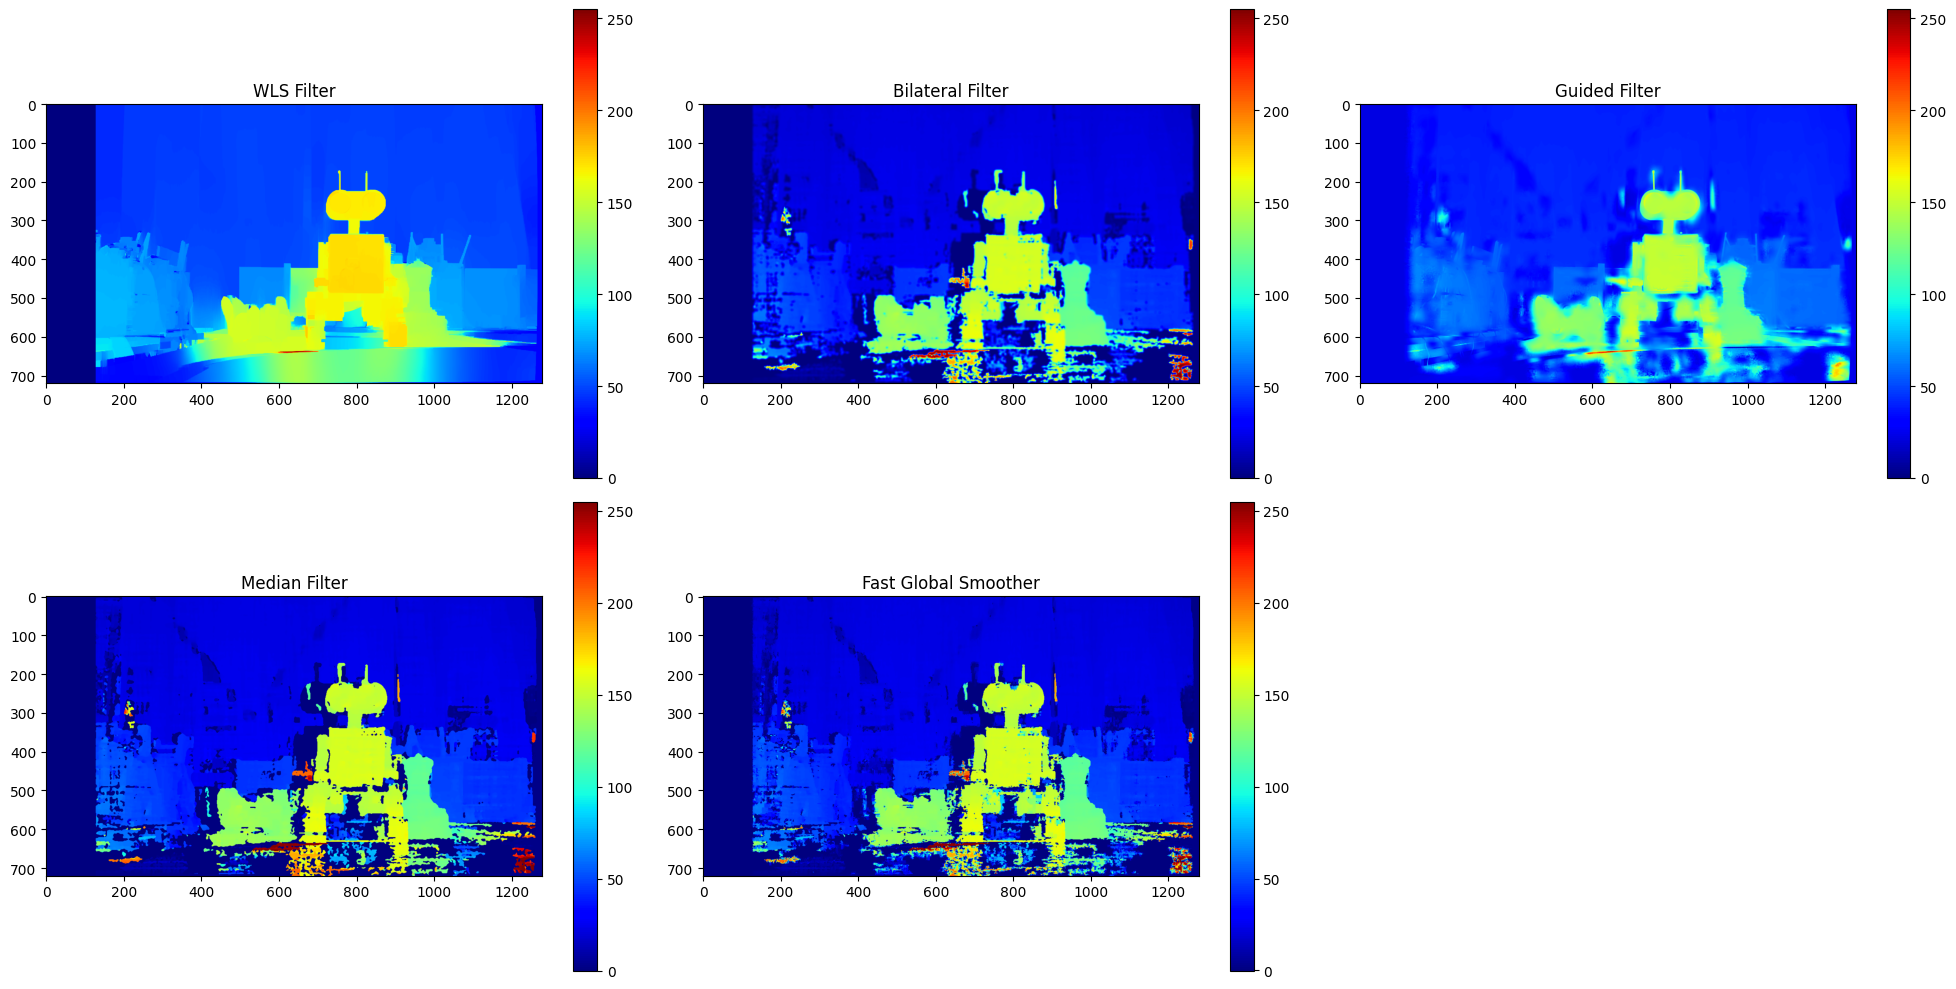

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load rectified stereo images
left_img_color = cv2.imread("rectified_img1.jpg")  # Load in color (BGR)
left_img = cv2.cvtColor(left_img_color, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
right_img = cv2.imread("rectified_img2.jpg", cv2.IMREAD_GRAYSCALE)

# Define StereoSGBM parameters
min_disparity = 0
num_disparities = 128  # Must be a multiple of 16
block_size = 5
uniqueness_ratio = 10
speckle_window_size = 100
speckle_range = 32
disp12_max_diff = 1
pre_filter_cap = 63

# Create StereoSGBM object
stereo_left = cv2.StereoSGBM_create(
    minDisparity=min_disparity,
    numDisparities=num_disparities,
    blockSize=block_size,
    uniquenessRatio=uniqueness_ratio,
    speckleWindowSize=speckle_window_size,
    speckleRange=speckle_range,
    disp12MaxDiff=disp12_max_diff,
    P1=8 * 3 * block_size**2,
    P2=32 * 3 * block_size**2,
    preFilterCap=pre_filter_cap,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

stereo_right = cv2.ximgproc.createRightMatcher(stereo_left)  # Right matcher for WLS

# Compute disparity maps
disparity_left = stereo_left.compute(left_img, right_img).astype(np.float32) / 16.0
disparity_right = stereo_right.compute(right_img, left_img).astype(np.float32) / 16.0

# Apply WLS filter
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=stereo_left)
wls_filter.setLambda(8000)  # Higher values smooth more
wls_filter.setSigmaColor(1.5)  # Edge-preserving filter
filtered_disparity_wls = wls_filter.filter(disparity_left, left_img, disparity_map_right=disparity_right)

# Apply Bilateral filter
filtered_disparity_bilateral = cv2.bilateralFilter(disparity_left, d=9, sigmaColor=75, sigmaSpace=75)

# Apply Guided filter
filtered_disparity_guided = cv2.ximgproc.guidedFilter(guide=left_img, src=disparity_left, radius=9, eps=0.01)

# # Apply Speckle filter
# filtered_disparity_speckle = cv2.filterSpeckles(disparity_left, 0, speckle_window_size, speckle_range)

# Apply Median filter
filtered_disparity_median = cv2.medianBlur(disparity_left, ksize=5)

# Apply Fast Global Smoother (FGS)
fgs_filter = cv2.ximgproc.createFastGlobalSmootherFilter(guide=left_img, lambda_=1000, sigma_color=0.1)
filtered_disparity_fgs = fgs_filter.filter(disparity_left)

# Normalize all disparity maps for visualization
def normalize_disparity(disparity):
    return cv2.normalize(disparity, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

filtered_disparity_wls_norm = normalize_disparity(filtered_disparity_wls)
filtered_disparity_bilateral_norm = normalize_disparity(filtered_disparity_bilateral)
filtered_disparity_guided_norm = normalize_disparity(filtered_disparity_guided)
filtered_disparity_median_norm = normalize_disparity(filtered_disparity_median)
filtered_disparity_fgs_norm = normalize_disparity(filtered_disparity_fgs)

# Plot all results
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.imshow(filtered_disparity_wls_norm, cmap="jet")
plt.colorbar()
plt.title("WLS Filter")

plt.subplot(2, 3, 2)
plt.imshow(filtered_disparity_bilateral_norm, cmap="jet")
plt.colorbar()
plt.title("Bilateral Filter")

plt.subplot(2, 3, 3)
plt.imshow(filtered_disparity_guided_norm, cmap="jet")
plt.colorbar()
plt.title("Guided Filter")

plt.subplot(2, 3, 4)
plt.imshow(filtered_disparity_median_norm, cmap="jet")
plt.colorbar()
plt.title("Median Filter")

plt.subplot(2, 3, 5)
plt.imshow(filtered_disparity_fgs_norm, cmap="jet")
plt.colorbar()
plt.title("Fast Global Smoother")

plt.tight_layout()
plt.show()

# Case 2: 3D reconstruction by Spares

## Feature matching, finding fundamental matrix, Essential matrix, Translation and Rotation Matrix

Total matches found: 836
Total strong matches after filtering: 492
Fundamenatal Matrix =  [[-5.00186320e-08 -7.08535095e-06  3.48674030e-03]
 [ 7.93311714e-06  3.99541918e-06 -2.33413925e-02]
 [-3.70426825e-03  1.90617086e-02  1.00000000e+00]]


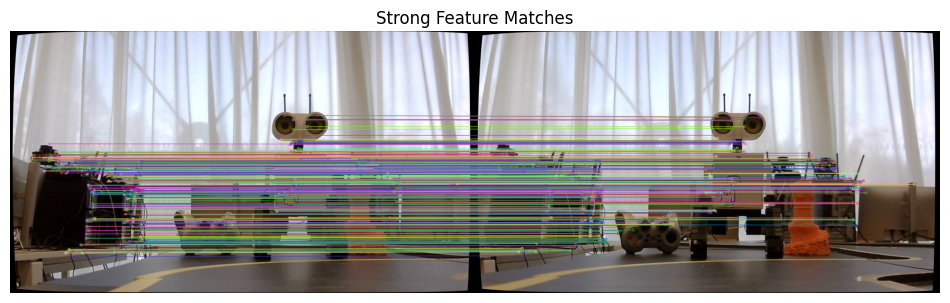

Essential Matrix:
[[-1.02364889e-01 -1.44164351e+01  1.13608222e+00]
 [ 1.61413696e+01  8.08232242e+00 -2.34467091e+01]
 [-1.08880062e+00  2.24388509e+01  1.77081984e-03]]
Possible Rotation Matrices:
[[ 0.38817409 -0.00898396  0.92154227]
 [ 0.14921747 -0.98614533 -0.07246748]
 [ 0.90942565  0.16564021 -0.38145551]]
[[ 0.9956282   0.07605321  0.05422535]
 [-0.08210167  0.98939826  0.11979319]
 [-0.04453981 -0.12372147  0.9913169 ]]
Translation Vector:
[0.8472794  0.0410939  0.52955538]


In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Feature Detection and Matching using SIFT

# surf = cv2.SURF_create()  # Updated SURF implementation
# bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

akaze = cv2.AKAZE_create()
bf_akaze = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# sift = cv2.SIFT_create()
# flann = cv2.FlannBasedMatcher()

# orb = cv2.ORB_create()
# bf_orb = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Detect keypoints and descriptors in both images
kp1, des1 = akaze.detectAndCompute(rectified_img1, None)
kp2, des2 = akaze.detectAndCompute(rectified_img2, None)

# Match features using FLANN-based matcher
matches = bf_akaze.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)  # Sort matches by distance

# Set a threshold to filter out weak matches
# This threshold can be adjusted based on your needs
threshold = 60 # Matches with distance < 50 are considered strong
good_matches = [m for m in matches if m.distance < threshold]

# Print number of good matches
print(f"Total matches found: {len(matches)}")
print(f"Total strong matches after filtering: {len(good_matches)}")

# Extract the matched keypoints for the good matches
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Use RANSAC to compute the Fundamental Matrix and filter out outliers
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=3)
print("Fundamenatal Matrix = ",F)
# Select inliers (good matches after RANSAC)
pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]


# Visualize the matched features after filtering with RANSAC
matched_img = cv2.drawMatches(rectified_img1, kp1, rectified_img2, kp2, good_matches, None, 
                              matchesMask=mask.ravel().tolist(), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matched features
plt.figure(figsize=(12, 6))
plt.imshow(cv2.cvtColor(matched_img, cv2.COLOR_BGR2RGB))
plt.title("Strong Feature Matches")
plt.axis("off")
plt.show()

# # Save the matched features image
cv2.imwrite("strong_feature_matches_with_ransac.jpg", matched_img)

# Compute Essential Matrix
E = K.T @ F @ K
print("Essential Matrix:")
print(E)

# Decompose Essential Matrix to get Rotation and Translation
U, S, Vt = np.linalg.svd(E)
W = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])

# Possible solutions
R1 = U @ W @ Vt
R2 = U @ W.T @ Vt
t = U[:, 2]

print("Possible Rotation Matrices:")
print(R1)
print(R2)
print("Translation Vector:")
print(t)


## Test the Essential and Fundamental matrix

In [13]:
U, S, Vt = np.linalg.svd(E)
print(f"Singular values of E: {S}")

# Check if the third singular value is (approximately) zero
if np.isclose(S[2], 0, atol=1e-5):
    print("Essential matrix has the correct rank (2).")
else:
    print("Essential matrix does NOT have the correct rank!")
det_E = np.linalg.det(E)
print(f"Det(E) = {det_E}")
if np.isclose(det_E, 0, atol=1e-5):
    print("Essential matrix satisfies det(E) = 0 condition.")
else:
    print("Essential matrix does NOT satisfy det(E) = 0 condition!")


# Verify rotation matrices
det_R1 = np.linalg.det(R1)
det_R2 = np.linalg.det(R2)

print(f"Det(R1) = {det_R1}, Det(R2) = {det_R2}")
identity_matrix = np.eye(3)

# Compute deviations from identity matrix
R1_deviation = np.linalg.norm(R1 - identity_matrix)
R2_deviation = np.linalg.norm(R2 - identity_matrix)

print(f"Deviation of R1 from Identity: {R1_deviation}")
print(f"Deviation of R2 from Identity: {R2_deviation}")
errors = []
for i in range(len(pts1)):
    x1 = np.append(pts1[i], 1)  # Convert to homogeneous coordinates
    x2 = np.append(pts2[i], 1)
    
    error = np.abs(x2.T @ F @ x1)  # Compute epipolar constraint error
    errors.append(error)

mean_error = np.mean(errors)
print(f"Mean Epipolar Constraint Error: {mean_error}")

Singular values of E: [3.20264290e+01 2.37433369e+01 6.94092028e-15]
Essential matrix has the correct rank (2).
Det(E) = 8.237717708962974e-13
Essential matrix satisfies det(E) = 0 condition.
Det(R1) = 1.0000000000000009, Det(R2) = 1.0000000000000009
Deviation of R1 from Identity: 2.821144002567274
Deviation of R2 from Identity: 0.21751614679610887
Mean Epipolar Constraint Error: 0.037000004225239407


# T#riangulate Points

In [14]:
import cv2
import numpy as np

# Camera intrinsic matrix (replace with actual values)
K  # Replace with actual intrinsic matrix

# Essential matrix and decomposed values
E  
R1  
R2  
T=t  
# Check and fix T
print("Original T shape:", T.shape)
if T.shape == (3,):
    T = T.reshape(3, 1)
print("Fixed T shape:", T.shape)

# Choose the correct rotation matrix (closest to identity)
identity_matrix = np.eye(3)
R1_deviation = np.linalg.norm(R1 - identity_matrix)
R2_deviation = np.linalg.norm(R2 - identity_matrix)

if R1_deviation < R2_deviation:
    R = R1
    print("Selected R1")
else:
    R = R2
    print("Selected R2")

# Compute projection matrices
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))  # P1 = K [I | 0]
P2 = K @ np.hstack((R, T))  # P2 = K [R | T]

# Ensure pts1 and pts2 are 2D
print("pts1 shape before reshape:", pts1.shape)
print("pts2 shape before reshape:", pts2.shape)

if pts1.ndim == 3:
    pts1 = pts1.reshape(-1, 2)
if pts2.ndim == 3:
    pts2 = pts2.reshape(-1, 2)

# Convert points to homogeneous coordinates
pts1_hom = np.vstack((pts1.T, np.ones((1, pts1.shape[0]))))  # Shape: (3, N)
pts2_hom = np.vstack((pts2.T, np.ones((1, pts2.shape[0]))))  # Shape: (3, N)

# Perform triangulation
points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_hom[:2], pts2_hom[:2])

# Convert from homogeneous to 3D coordinates
points_3d = points_4d_hom[:3] / points_4d_hom[3]  # Shape: (3, N)

# Filter out points with negative depth (Z should be positive)
valid_indices = points_3d[2] > 0
points_3d_filtered = points_3d[:, valid_indices]

# Print results
print("Reconstructed 3D Points (filtered):")
print(points_3d_filtered.T)  # Shape: (valid_N, 3)



Original T shape: (3,)
Fixed T shape: (3, 1)
Selected R2
pts1 shape before reshape: (492, 1, 2)
pts2 shape before reshape: (492, 1, 2)
Reconstructed 3D Points (filtered):
[]


## Plot the 3d points

In [15]:
import open3d as o3d

# Load your point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d.T)  # Convert numpy to Open3D format

# Apply statistical outlier removal
pcd_filtered, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

# Visualize before and after
o3d.visualization.draw_geometries([pcd], window_name="Noisy Point Cloud")
o3d.visualization.draw_geometries([pcd_filtered], window_name="Filtered Point Cloud")

## 3D points with Color

In [16]:
import cv2
import numpy as np
import open3d as o3d

# Load the original images
img1 = cv2.imread("first/1.jpg")  # Replace with the path to your first image
img2 = cv2.imread("first/2.jpg")  # Replace with the path to your second image

# Ensure the images are in RGB format (OpenCV loads them in BGR by default)
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Reshape pts1 and pts2 to (N, 2) format
pts1 = pts1.reshape(-1, 2)  # Shape: (482, 2)
pts2 = pts2.reshape(-1, 2)  # Shape: (482, 2)

# Extract colors from the first image (img1)
colors = []
for pt in pts1:
    x, y = int(pt[0]), int(pt[1])  # Convert to integer coordinates
    if 0 <= x < img1_rgb.shape[1] and 0 <= y < img1_rgb.shape[0]:  # Check if within image bounds
        color = img1_rgb[y, x] / 255.0  # Normalize to [0, 1] for Open3D
        colors.append(color)
    else:
        colors.append([0, 0, 0])  # Default to black if out of bounds

# Convert colors to a numpy array
colors = np.array(colors)

# Create Open3D point cloud
point_cloud = o3d.geometry.PointCloud()
point_cloud.points = o3d.utility.Vector3dVector(points_3d.T)  # Assign 3D points
point_cloud.colors = o3d.utility.Vector3dVector(colors)  # Assign colors

# Visualize the colored point cloud
o3d.visualization.draw_geometries([point_cloud])

## 3D points on original image

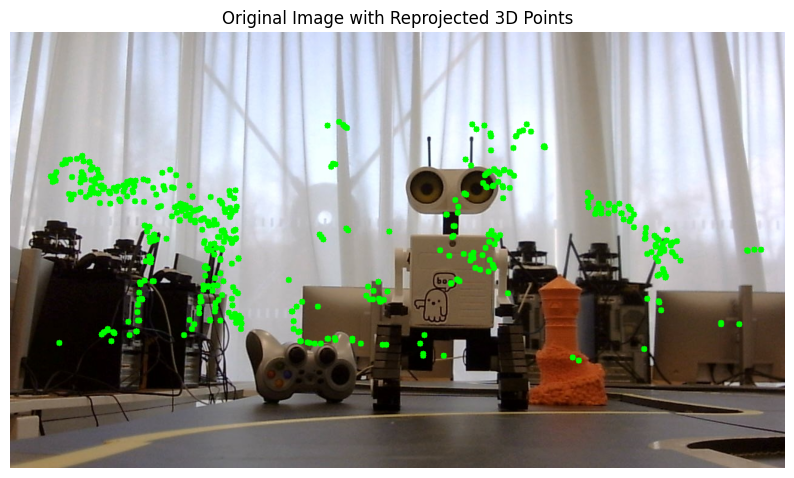

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming you already have the following:
# - points_3d: Reconstructed 3D points (shape: 3xN)
# - K: Camera intrinsic matrix
# - R, T: Rotation and translation between the two cameras
# - img1: Original first image (before rectification)

# Step 1: Define the projection matrix for the first camera
P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))  # P1 = K [I | 0]

# Step 2: Reproject 3D points onto the first image
points_4d_hom = np.vstack((points_3d, np.ones((1, points_3d.shape[1]))))  # Convert to homogeneous coordinates
reprojected_pts = P1 @ points_4d_hom  # Project to 2D
reprojected_pts = reprojected_pts[:2] / reprojected_pts[2]  # Normalize to get (u, v) coordinates


# Step 3: Visualize the reprojected points on the original image
img1_with_points = img1.copy()  # Make a copy of the original image

# Draw the reprojected points on the image
for pt in reprojected_pts.T:
    u, v = int(pt[0]), int(pt[1])  # Convert to integer pixel coordinates
    cv2.circle(img1_with_points, (u, v), radius=5, color=(0, 255, 0), thickness=-1)  # Green points

# Display the image with reprojected points
plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(img1_with_points, cv2.COLOR_BGR2RGB))
plt.title("Original Image with Reprojected 3D Points")
plt.axis('off')
plt.show()